In [1]:
import numpy as np
from shapely.ops import split
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon, LineString
import ee
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import shutil
import torchvision

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Autenticación
gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # Se abrirá una ventana del navegador para autenticación

# Crear un objeto de GoogleDrive utilizando la autenticación
drive = GoogleDrive(gauth)

id_carpeta = '1TvcWff-3Qt-U7WFuzRDRRbnP3UHHezVB'

archivos_en_carpeta = drive.ListFile({'q': f"'{id_carpeta}' in parents and trashed=false"}).GetList()

for archivo in archivos_en_carpeta:
    try:
        archivo.Delete()
        print(f"Archivo '{archivo['title']}' eliminado correctamente.")
    except:
        print(f"No se pudo eliminar el archivo '{archivo['title']}'.")

print("Archivos en la carpeta eliminados correctamente.")


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=323993679713-adacepmouf1ruhtl5e5fv49rfgp9j3ko.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
Archivo 'RectangleExport.tif' eliminado correctamente.
Archivos en la carpeta eliminados correctamente.


In [3]:
def crear_archivo_shapefile(geometry, nombre):

    #print(geometry)
    polygon = Polygon(tuple(geometry))

    gdf = gpd.GeoDataFrame({'geometry': [polygon]})


    directorio = './shapefileSubimagen/'+ nombre+'/'

    if not os.path.exists(directorio):
        os.makedirs(directorio)

    ruta_guardar = './shapefileSubimagen/'+ nombre+'/' + nombre +'.shp'

    gdf.to_file(ruta_guardar)

    #print(f'Shapefile guardado en: {ruta_guardar}')
    return ruta_guardar

def eliminar_contenido_carpeta(carpeta_a_eliminar ):
    if os.path.exists(carpeta_a_eliminar):
        for contenido in os.listdir(carpeta_a_eliminar):
            contenido_ruta = os.path.join(carpeta_a_eliminar, contenido)
            if os.path.isfile(contenido_ruta):
                os.remove(contenido_ruta)
            elif os.path.isdir(contenido_ruta):
                shutil.rmtree(contenido_ruta)
        os.rmdir(carpeta_a_eliminar)
    else:
        print(f"La carpeta '{carpeta_a_eliminar}' no existe.")

def descargar_imagen_sentinel_full(geometry, fecha_inicio, fecha_fin, tipoImagen, carpeta_destino, index):
    import io
    import cv2

    band = ['B4', 'B3', 'B2']
    if not os.path.exists(carpeta_destino):
      os.makedirs(carpeta_destino)

    # Inicializar la API de Google Earth Engine
    ee.Initialize()

    # Definir la geometría
    geometry = ee.Geometry.Polygon(
      [geometry], None, False);
    # Load Sentinel-2 TOA reflectance data
    dataset = ee.ImageCollection('COPERNICUS/S2') \
        .filterDate(fecha_inicio, fecha_fin) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .filterBounds(geometry) \
        .median()


    #datasetClip = dataset.clip(geometry)
    #imagenRGB = datasetClip.visualize(**{'min': 0,'max': 2500, 'bands': band})
    extension = 'tif'

    # Multi-band GeoTIFF file.
    url = dataset.getDownloadUrl({
        'bands': band,
        'region': geometry,
        'scale': 10,
        'format': 'NPY'
    })
    import numpy

    response = requests.get(url)
    data = numpy.load(io.BytesIO(response.content))

    # Convert 16-bit data to 8-bit for each band
    bands_8bit = []
    for band_name in band:
        band_data = data[band_name]
        min_val = 0
        max_val = 2750 #band_data.max()
        band_8bit = ((band_data - min_val) / (max_val - min_val)) * 255
        band_8bit = np.clip(band_8bit, 0, 255).round().astype(np.uint8)
        bands_8bit.append(band_8bit)

    # Stack bands together
    data_8bit = np.stack(bands_8bit, axis=-1)


    # Save as PNG
    #image = Image.fromarray(data_8bit.transpose(1, 2, 0))  # Convert from CxHxW to HxWxC
    image_path = os.path.join(carpeta_destino, f'sentinel2_{index}.png')
    cv2.imwrite(image_path, cv2.cvtColor(data_8bit, cv2.COLOR_RGB2BGR))

    return image_path, image_path

def extract_patch_from_masked_data(red_clip, green_clip, blue_clip, mask):
    # Find where the mask is True
    rows, cols = np.where(mask)

    # Get the bounding box coordinates
    top_row = np.min(rows)
    bottom_row = np.max(rows)
    left_col = np.min(cols)
    right_col = np.max(cols)

    # Extract the patch using the bounding box
    red_patch = red_clip[top_row:bottom_row+1, left_col:right_col+1]
    green_patch = green_clip[top_row:bottom_row+1, left_col:right_col+1]
    blue_patch = blue_clip[top_row:bottom_row+1, left_col:right_col+1]

    return red_patch, green_patch, blue_patch

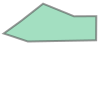

In [4]:
geo_filepath = "./shapefiles/nombre_shapefile.shp"
GeoDF = gpd.read_file(geo_filepath)
G = np.random.choice(GeoDF.geometry.values)
Rectangle = G.envelope
G

In [5]:
ee.Initialize()

In [6]:
import geopandas as gpd
import numpy as np
import ee

# Initialize the Earth Engine library.
ee.Initialize()

def export_rectangle_to_drive(Rectangle, scale=10):
    """
    Exports the envelope of a geometry from a shapefile to Google Drive.

    Args:
    - geo_filepath (str): Path to the shapefile.
    - scale (int): Resolution scale. Default is 10 for Sentinel-2.

    Returns:
    - str: Status of the export task.
    """

    # Convert the shapely geometry to an Earth Engine Geometry
    coords = list(Rectangle.exterior.coords)
    region = ee.Geometry.Polygon(coords)

    # Define the image collection for Sentinel-2 and filter by the region
    collection = ee.ImageCollection('COPERNICUS/S2') \
        .filterDate("2018-01-01","2019-01-01") \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .filterBounds(region) \

    # Get the first image from the collection
    image = collection.median().select(['B4', 'B3', 'B2'])  # RGB bands for Sentinel-2

    # Define export parameters
    task_config = {
        'description': 'RectangleExport',
        'folder': 'rasters',
        'fileNamePrefix': 'RectangleExport', 
        'scale': scale,
        'region': region,
        'maxPixels': 1e13  # Increase this if you get an error related to pixel count
    }

    # Start the export task to Google Drive
    task = ee.batch.Export.image.toDrive(image, **task_config)
    task.start()

    return task

def check_task_status(task):
    return task.status()

# Call the function
task = export_rectangle_to_drive(Rectangle)

import time

while task.active():
    print("Polling for task (id: {}).".format(task.id))
    time.sleep(10)  # Wait for 5 minutes
    status = check_task_status(task)
    print(status)


Polling for task (id: LINZJF2CCKLD7EIZ4XITKIJT).
{'state': 'RUNNING', 'description': 'RectangleExport', 'creation_timestamp_ms': 1701130227599, 'update_timestamp_ms': 1701130232667, 'start_timestamp_ms': 1701130230291, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LINZJF2CCKLD7EIZ4XITKIJT', 'name': 'projects/earthengine-legacy/operations/LINZJF2CCKLD7EIZ4XITKIJT'}
Polling for task (id: LINZJF2CCKLD7EIZ4XITKIJT).
{'state': 'RUNNING', 'description': 'RectangleExport', 'creation_timestamp_ms': 1701130227599, 'update_timestamp_ms': 1701130232667, 'start_timestamp_ms': 1701130230291, 'task_type': 'EXPORT_IMAGE', 'attempt': 1, 'id': 'LINZJF2CCKLD7EIZ4XITKIJT', 'name': 'projects/earthengine-legacy/operations/LINZJF2CCKLD7EIZ4XITKIJT'}
Polling for task (id: LINZJF2CCKLD7EIZ4XITKIJT).
{'state': 'RUNNING', 'description': 'RectangleExport', 'creation_timestamp_ms': 1701130227599, 'update_timestamp_ms': 1701130232667, 'start_timestamp_ms': 1701130230291, 'task_type': 'EXPORT_IMAGE', 'attempt':

In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive


drive = GoogleDrive(gauth)

def get_file_id_by_name(filename):
    """
    Get the file ID of a file in Google Drive based on its name.

    Args:
    - filename (str): The name of the file.

    Returns:
    - str: The file ID or None if not found.
    """

    # Search for the file by its name
    file_list = drive.ListFile({'q': f"title='{filename}'"}).GetList()

    # If the file is found, return its ID
    for file in file_list:
        if file['title'] == filename:
            return file['id']
    return None

# Usage
file_id = get_file_id_by_name('RectangleExport.tif')

downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('downloaded_image.tif')

In [9]:
side_length = 0.02


rect_coords = np.array(Rectangle.boundary.coords.xy)


y_list = rect_coords[1]
x_list = rect_coords[0]


y1 = min(y_list)
y2 = max(y_list)


x1 = min(x_list)
x2 = max(x_list)


width = x2 - x1
height = y2 - y1


#xcells = int(np.round(width / side_length))
#ycells = int(np.round(height / side_length))

xcells = 30 
ycells = 15

yindices = np.linspace(y1, y2, ycells + 1)
xindices = np.linspace(x1, x2, xcells + 1)

print(xcells, ycells)

width,height

30 15


(0.337169585456806, 0.13762882422256695)

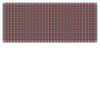

In [10]:
horizontal_splitters = [
    LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
]

vertical_splitters = [
    LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
]

result = Rectangle

for splitter in vertical_splitters:
    result = MultiPolygon(split(result, splitter))

for splitter in horizontal_splitters:
    result = MultiPolygon(split(result, splitter))


result

In [11]:
square_polygons = list(result.geoms)
df = gpd.GeoDataFrame(square_polygons)
SquareGeoDF  = gpd.GeoDataFrame(square_polygons).rename(columns={0: "geometry"})
SquareGeoDF = gpd.GeoDataFrame(square_polygons)

SquareGeoDF = SquareGeoDF.set_geometry(0)

Geoms = SquareGeoDF[SquareGeoDF.intersects(G)].geometry.values
shape = "square"
thresh = 0.9


if shape == "rhombus":
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]
elif shape == "square":
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

len(geoms)

grid = gpd.GeoDataFrame({'geometry':geoms})
len(geoms)

266

In [18]:
class_id_to_label = {
    0: "ann_crop",
    1: "forest",
    2: "herb_veg",
    3: "highway",
    4: "industrial",
    5: "pasture",
    6: "perm_crop",
    7: "residential",
    8: "river",
    9: "sea_lake"
}

class_id_to_color = {
    0: (0, 0, 255),  # Red
    1: (0, 100, 0),  # Blue
    2: (0, 255, 0),  # Green
    3: (0, 255, 255),  # Yellow
    4: (0, 165, 255),  # Orange
    5: (128, 0, 128),  # Purple
    6: (145, 176, 255),  # Cyan
    7: (255, 0, 255),  # Magenta
    8: (128, 0, 0),  # Brown
    9: (235, 206, 135)  # Lime
}

## MODELO VIT_B_16

In [26]:
import torch
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import cv2
from rasterio.features import geometry_mask
from shapely.geometry import mapping
import torch
from torchvision import models, transforms
import torch.nn.functional as F  # Import functional interface
from PIL import Image
from torch import nn

In [21]:

# Load Model
path = './models/ViT_Satellite.pth'
# 1. Get pretrained weights for ViT-Base
model_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available


# Get automatic transforms from pretrained ViT weights
transform_im = model_weights.transforms()
print(transform_im)

# 2. Setup a ViT model instance with pretrained weights
model = torchvision.models.vit_b_16(weights=model_weights).to(device)


# 3. Freeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
model.heads = nn.Linear(in_features=768, out_features=10).to(device)
model.load_state_dict(torch.load(path, map_location='cpu'))

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


FileNotFoundError: [Errno 2] No such file or directory: './models/ViT_Satellite.pth'

## MODELO CNN effnetb0

In [39]:
def create_effnetb2_model(num_classes:int=10, # default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [40]:


# Setup best model filepath
best_model_path = "models/CNN_EffNetB2_Data_20_percent.pth"

# Instantiate a new instance of EffNetB2 (to load in the saved state_dict())
model, transform_im = create_effnetb2_model()
model.to(device)
# Load the saved best model state_dict()
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))


<All keys matched successfully>

## MODELO SWINV2

In [198]:
# Load Model
"""
transform_im = transforms.Compose([transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                        [0.229, 0.224, 0.225])])

path = './models/swinv2_model.pt'

model = models.swin_v2_b(weights=None)
model.head = torch.nn.Linear(model.head.in_features, 10)
model.to(device)
model.load_state_dict(torch.load(path, map_location='cpu'))
"""

"\ntransform_im = transforms.Compose([transforms.Resize((64, 64), transforms.InterpolationMode.BICUBIC),\n                                                    transforms.ToTensor(),\n                                                    transforms.Normalize([0.485, 0.456, 0.406],\n                                                                        [0.229, 0.224, 0.225])])\n\npath = './models/swinv2_model.pt'\n\nmodel = models.swin_v2_b(weights=None)\nmodel.head = torch.nn.Linear(model.head.in_features, 10)\nmodel.to(device)\nmodel.load_state_dict(torch.load(path, map_location='cpu'))\n"

Predicted class: sea_lake, Probability: 36.12%
Predicted class: forest, Probability: 44.18%
Predicted class: pasture, Probability: 62.47%
Predicted class: residential, Probability: 33.05%
Predicted class: residential, Probability: 64.49%
Predicted class: pasture, Probability: 83.85%
Predicted class: forest, Probability: 55.88%
Predicted class: forest, Probability: 29.35%
Predicted class: pasture, Probability: 53.35%
Predicted class: forest, Probability: 49.92%
Predicted class: sea_lake, Probability: 61.46%
Predicted class: sea_lake, Probability: 57.87%
Predicted class: sea_lake, Probability: 90.60%
Predicted class: forest, Probability: 72.76%
Predicted class: residential, Probability: 62.58%
Predicted class: residential, Probability: 25.59%
Predicted class: residential, Probability: 92.20%
Predicted class: residential, Probability: 96.91%
Predicted class: residential, Probability: 76.15%
Predicted class: residential, Probability: 67.03%
Predicted class: residential, Probability: 75.77%

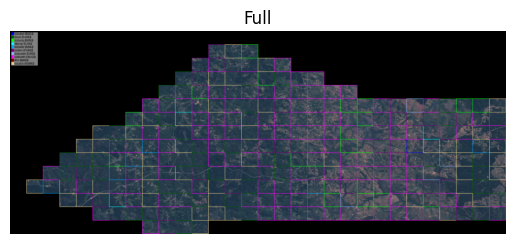

In [41]:


# Count instances
class_percentages = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0
}


model.eval()

bboxes = []

with rasterio.open('downloaded_image.tif') as src:
    # Read the RGB bands
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    transform = src.transform
    crs = src.crs

    full_mask = np.zeros_like(red, dtype=bool)
    forest = 0

    for i, polygon in enumerate(geoms):
        
        # Convert to pixel coordinates
        pixel_polygon = [~transform * (x, y) for x, y in polygon.exterior.coords]
        
        # Create a mask for the polygon
        geojson_polygon = mapping(polygon)
        mask = geometry_mask([geojson_polygon], transform=transform, invert=True, out_shape=src.shape)
        full_mask = np.logical_or(full_mask, mask)
        
        red_clip = src.read(1) * mask
        green_clip = src.read(2) * mask
        blue_clip = src.read(3) * mask

        red_patch, green_patch, blue_patch = extract_patch_from_masked_data(red_clip, green_clip, blue_clip, mask)

        pixel_shapely_polygon = Polygon(pixel_polygon)
        x1, y1, x2, y2 = pixel_shapely_polygon.bounds
        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)

        bands_8bit = []
        for band_name in [red_patch, green_patch, blue_patch]:
            band_data = band_name
            min_val = 0
            max_val = 2750
            band_8bit = ((band_data - min_val) / (max_val - min_val)) * 255
            band_8bit = np.clip(band_8bit, 0, 255).round().astype(np.uint8)
            bands_8bit.append(band_8bit)

        data_8bit = np.stack(bands_8bit, axis=-1)

        # Inference

        pil_image = Image.fromarray(data_8bit)
        tensor_im  = transform_im(pil_image).unsqueeze(0)

        with torch.no_grad():
            outputs = model(tensor_im.to(device))
            
            # Convert raw output scores to probabilities
            probabilities = F.softmax(outputs, dim=1)
            
            # Get the predicted class and its probability
            _, preds = torch.max(outputs, 1)
            pred_class = preds.item()
            pred_prob = probabilities[0][pred_class].item()

            bboxes.append([pred_class, pred_prob, x1, y1, x2, y2])

            print(f"Predicted class: {class_id_to_label[pred_class]}, Probability: {pred_prob * 100:.2f}%")

            if pred_class == 1:
                forest += 1

        #cv2.imwrite(f'subimages/sub_{i}.png', cv2.cvtColor(data_8bit, cv2.COLOR_RGB2BGR))
        
    # Save or visualize the clipped image

    # Apply the mask to the RGB bands
    red_masked = np.where(full_mask, red, 0)
    green_masked = np.where(full_mask, green, 0)
    blue_masked = np.where(full_mask, blue, 0)

    bands_8bit = []
    for band_name in [red_masked, green_masked, blue_masked]:
        band_data = band_name
        min_val = 0
        max_val = 2750 #band_data.max()
        band_8bit = ((band_data - min_val) / (max_val - min_val)) * 255
        band_8bit = np.clip(band_8bit, 0, 255).round().astype(np.uint8)
        bands_8bit.append(band_8bit)

    data_8bit = np.stack(bands_8bit, axis=-1)

    cv2.imwrite(f'full_geom.png', cv2.cvtColor(data_8bit, cv2.COLOR_RGB2BGR))

    print(len(geoms), len(bboxes))

    for bbox in bboxes:
        cv2.rectangle(data_8bit, (bbox[2], bbox[3]), (bbox[4], bbox[5]), class_id_to_color[bbox[0]], 2)
        class_percentages[bbox[0]] += 1

    total = 0

    for k in class_percentages:
        class_percentages[k] = (class_percentages[k] / len(geoms)) * 100
        total += class_percentages[k]

    print("Total:", total)

    legend_height = 25  # Height of each legend item
    legend_x = 10  # X-position of legend
    legend_y_start = 10  # Starting Y-position

    # Create an overlay with the same dimensions as the original image
    overlay = data_8bit.copy()

    # Calculate legend area dimensions
    legend_area_height = len(class_id_to_label) * legend_height
    legend_area_width = 200  # you can customize this width

    # Draw semi-transparent white rectangle as legend background
    cv2.rectangle(overlay, (legend_x, legend_y_start), (legend_x + legend_area_width, legend_y_start + legend_area_height), (255, 255, 255), -1)

    # Add the overlay with alpha blending to create transparency effect
    alpha = 0.5  # Set transparency factor
    cv2.addWeighted(overlay, alpha, data_8bit, 1 - alpha, 0, data_8bit)

    # Draw colored squares and labels on the legend area
    for class_id, label in class_id_to_label.items():
        color = class_id_to_color[class_id]
        legend_y = legend_y_start + class_id * legend_height  # Calculate Y-position for this class
        cv2.rectangle(data_8bit, (legend_x, legend_y), (legend_x + 20, legend_y + 20), color, -1)  # Draw colored square

        percentage_text = f"{label} ({class_percentages[class_id]:.2f}%)"
        cv2.putText(data_8bit, percentage_text, (legend_x + 25, legend_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3, cv2.LINE_AA)  # Draw text label
        cv2.putText(data_8bit, percentage_text, (legend_x + 25, legend_y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)  # Draw text label

    cv2.imwrite(f'full_geom_drawn.png', cv2.cvtColor(data_8bit, cv2.COLOR_RGB2BGR))

    print(f"% de bosques en imagen: {(forest / len(geoms))* 100:.2f}%")

    plt.imshow(data_8bit)
    plt.title(f"Full")
    plt.axis('off')
    plt.show()